Total original samples: 34060
Epoch 1/100


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1363/1363 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 33269.0391 - mae: 128.5080 - val_loss: 10882.5039 - val_mae: 80.4323
Epoch 2/100
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9937.8564 - mae: 74.9762 - val_loss: 9538.0957 - val_mae: 69.5344
Epoch 3/100
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9113.8848 - mae: 68.1908 - val_loss: 9107.1240 - val_mae: 66.7856
Epoch 4/100
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8668.8984 - mae: 64.9162 - val_loss: 8604.1768 - val_mae: 63.7097
Epoch 5/100
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8292.5986 - mae: 62.5768 - val_loss: 8180.7939 - val_mae: 62.1819
Epoch 6/100
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7972.4282 - mae: 60.7806 - val_loss: 8046.7661 - val_mae: 60.3140
Epoch 7/100
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7682.2344 - mae: 59.0930 - val_loss: 7685.4810 - val_mae: 57.7358
Epoch 8/100
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7410.2852 - mae: 57.2989 - val_loss: 7455.9

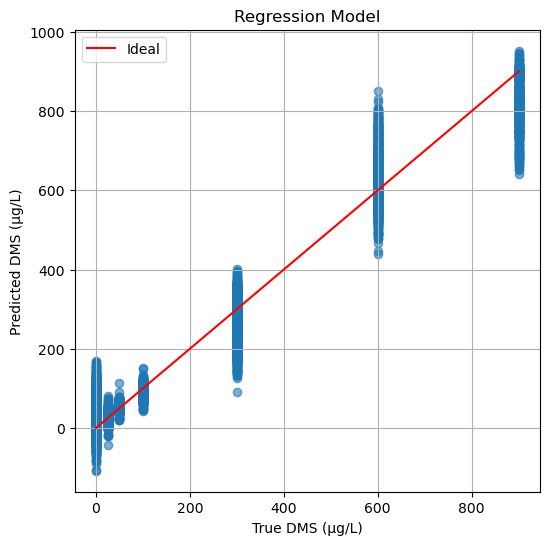

R-squared: 0.9610


In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import joblib

# --- 1. LOAD DATA ---
base_dir1 = r"C:\Users\DELL\OneDrive\Documents\Smart Brewery\Measurements\Measurements 31.10.2025"
base_dir2 = r"C:\Users\DELL\OneDrive\Documents\Smart Brewery\Measurements\Measurements 04.11.2025"

files = {
    0: os.path.join(base_dir1, "water.csv"),
    25: os.path.join(base_dir1, "25 mcg_L DMS.csv"),
    50: os.path.join(base_dir1, "50 mcg_L DMS.csv"),
    100: os.path.join(base_dir1, "100 mcg_L DMS.csv"),  
    300: os.path.join(base_dir2, "300 mcg_L DMS.csv"),
    600: os.path.join(base_dir2, "600 mcg_L DMS.csv"),
    900: os.path.join(base_dir2, "900 mcg_L DMS.csv")
}


data = pd.concat([pd.read_csv(path).assign(target=conc) for conc, path in files.items()], ignore_index=True)

# --- 2. PREPROCESSING ---
drop_cols = [
    "id", "timestamp", "label", "sensorID",  
    "measurementID", "heaterProfileID",       
    "timeSincePowerOn", "stepIndex"           
]

X = data.drop(columns=drop_cols + ["target"], errors='ignore')
y = data["target"]

print(f"Total original samples: {len(y)}")

# --- 3. SCALE AND SPLIT ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y.values, test_size=0.2, random_state=42
)

# --- 4. MODEL DEFINITION ---
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- 5. TRAINING ---
callback = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    verbose=1,
    callbacks=[callback]
)

# --- 6. EVALUATION ---
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"\nTest MAE: {test_mae:.3f} µg/L")

# Save model & scaler
joblib.dump(scaler, 'dms_scaler_0_900.pkl')
model.save('dms_model_0_900.keras')

# --- 7. VISUALIZATION ---
y_pred = model.predict(X_test).flatten()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, 900], [0, 900], 'r', label='Ideal')
plt.xlabel("True DMS (µg/L)")
plt.ylabel("Predicted DMS (µg/L)")
plt.title("Regression Model")
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


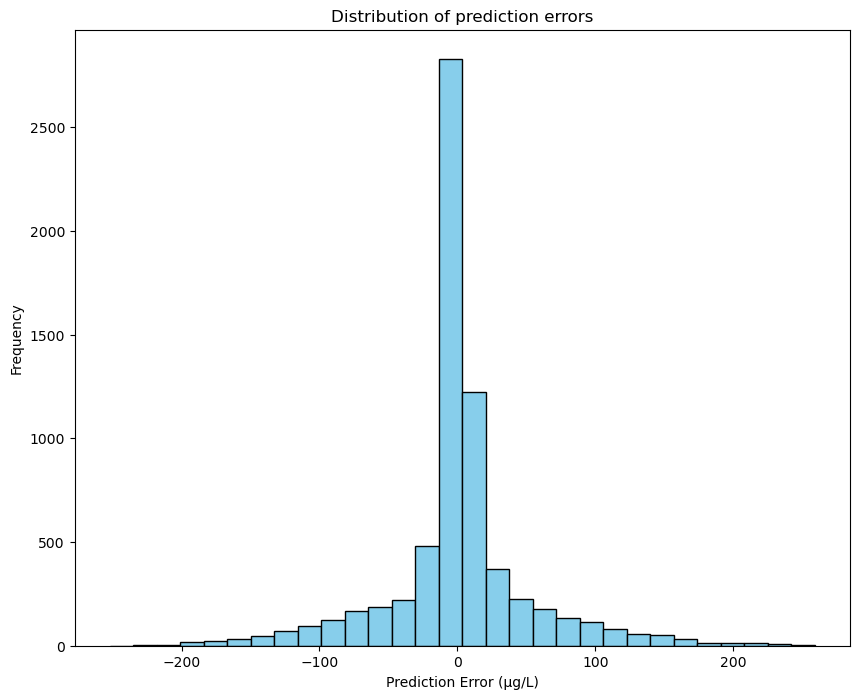

In [17]:
y_pred = model.predict(X_test).flatten()
residuals = y_test - y_pred
plt.figure(figsize=(10,8))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of prediction errors")
plt.xlabel("Prediction Error (µg/L)")
plt.ylabel("Frequency")
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_7052\3445017993.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_by_range = df_eval.groupby("Range")["Error"].mean()


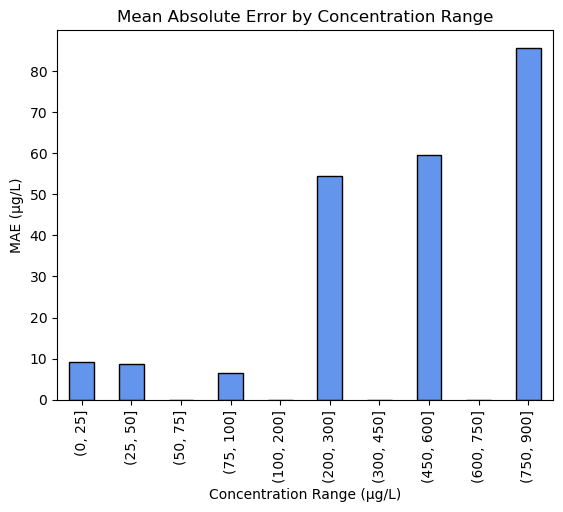

In [15]:
import pandas as pd
df_eval = pd.DataFrame({"True": y_test, "Pred": y_pred})
df_eval["Error"] = np.abs(df_eval["True"] - df_eval["Pred"])
df_eval["Range"] = pd.cut(df_eval["True"], bins=[0,25,50,75,100,200,300,450,600,750,900])

mae_by_range = df_eval.groupby("Range")["Error"].mean()
mae_by_range.plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title("Mean Absolute Error by Concentration Range")
plt.ylabel("MAE (µg/L)")
plt.xlabel("Concentration Range (µg/L)")
plt.show()